In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
%matplotlib inline
plt.style.use("fivethirtyeight")

# Initial exploration

In [3]:
df = pd.read_csv("blackjack.csv")

In [4]:
df.shape

(50000, 20)

In [5]:
df.describe()

,num_decks,dealer_open,dealer_initial,dealer_hit,dealer_num_hits,dealer_final,dealer_busts,player_card_one,player_card_two,player_initial,player_hit,player_num_hits,player_final,player_busts,player_loses,draw,player_wins,strategy
count,50000.0,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,4.0,6.53308,14.574800,0.405620,0.557560,18.088800,0.176120,6.546360,6.542220,14.549780,0.577220,0.845060,19.911240,0.299480,0.549280,0.071380,0.379340,0.500000
std,0.0,3.15958,4.095395,0.491017,0.778626,4.349595,0.380926,3.152689,3.142454,4.061912,0.494006,0.892631,3.894245,0.458035,0.497571,0.257461,0.485228,0.500005
min,4.0,1.00000,4.000000,0.000000,0.000000,4.000000,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.0,4.00000,12.000000,0.000000,0.000000,16.000000,0.000000,4.000000,4.000000,12.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.0,7.00000,15.000000,0.000000,0.000000,19.000000,0.000000,7.000000,7.000000,15.000000,1.000000,1.000000,20.000000,0.000000,1.000000,0.000000,0.000000,0.500000
75%,4.0,10.00000,18.000000,1.000000,1.000000,21.000000,0.000000,10.000000,10.000000,18.000000,1.000000,1.000000,22.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,4.0,10.00000,21.000000,1.000000,5.000000,26.000000,1.000000,10.000000,10.000000,21.000000,1.000000,6.000000,28.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.groupby("strategy")[["player_wins"]].sum()

,player_wins
strategy,
0,9004
1,9963


## Dealer's open card

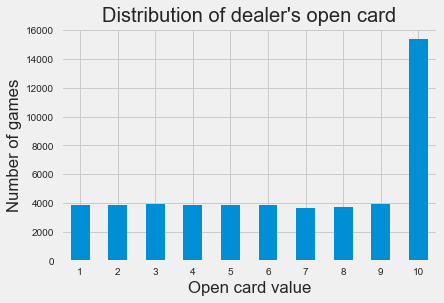

In [7]:
df["dealer_open"].value_counts(sort=False).plot(kind="bar", rot=0);
plt.xlabel("Open card value");
plt.ylabel("Number of games");
plt.title("Distribution of dealer's open card");

## Player's card one

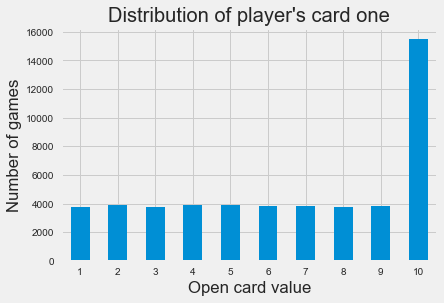

In [8]:
df["player_card_one"].value_counts(sort=False).plot(kind="bar", rot=0);
plt.xlabel("Open card value");
plt.ylabel("Number of games");
plt.title("Distribution of player's card one");

## Player's card two

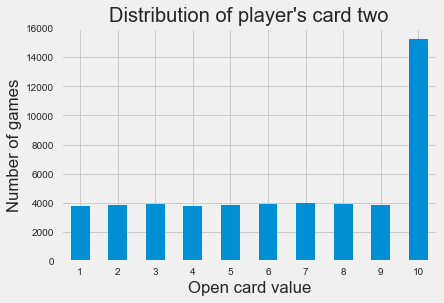

In [9]:
df["player_card_two"].value_counts(sort=False).plot(kind="bar", rot=0);
plt.xlabel("Open card value");
plt.ylabel("Number of games");
plt.title("Distribution of player's card two");

## Player's possible points

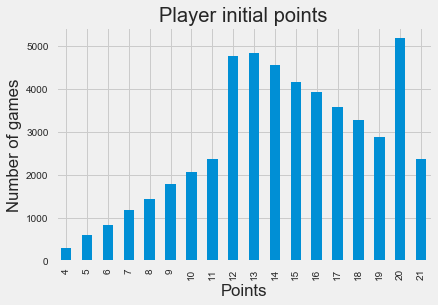

In [10]:
df.player_initial.value_counts().sort_index().plot(kind="bar");
plt.xlabel("Points");
plt.ylabel("Number of games");
plt.title("Player initial points");

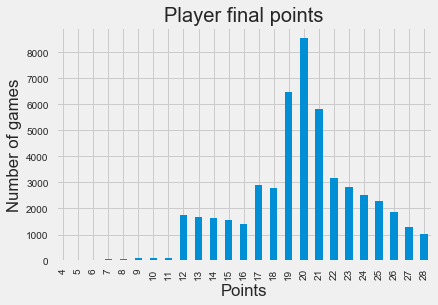

In [11]:
df.player_final.value_counts().sort_index().plot(kind="bar");
plt.xlabel("Points");
plt.ylabel("Number of games");
plt.title("Player final points");

## Dealer's possible points

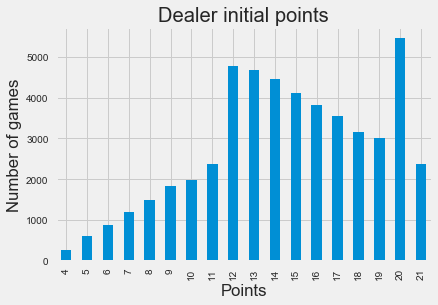

In [12]:
df.dealer_initial.value_counts().sort_index().plot(kind="bar");
plt.xlabel("Points");
plt.ylabel("Number of games");
plt.title("Dealer initial points");

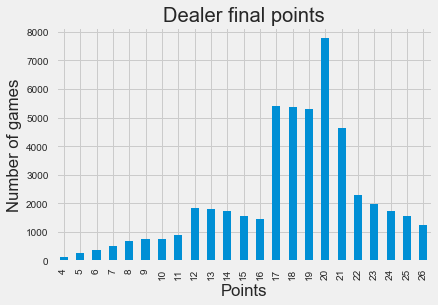

In [13]:
df.dealer_final.value_counts().sort_index().plot(kind="bar");
plt.xlabel("Points");
plt.ylabel("Number of games");
plt.title("Dealer final points");

## Comparison of final points

In [25]:
player = df.player_final.value_counts().sort_index().to_frame()
player.reset_index(inplace=True)
player.columns = ["final_points", "num_games"]
dealer = df.dealer_final.value_counts().sort_index().to_frame()
dealer.reset_index(inplace=True)
dealer.columns = ["final_points", "num_games"]

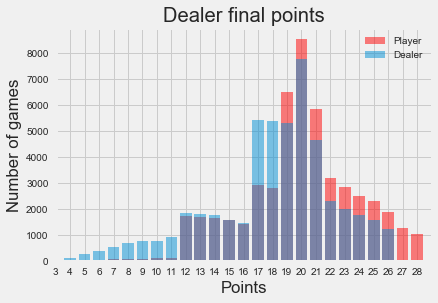

In [31]:
plt.bar(player.final_points, player.num_games, label="Player", 
        color="r", alpha=0.5)
plt.bar(dealer.final_points, dealer.num_games, label="Dealer", 
        alpha=0.5)
plt.xlabel("Points");
plt.ylabel("Number of games");
plt.title("Dealer final points");
plt.xlim(3,29);
plt.xticks(np.arange(3,29));
plt.legend();

## Findings

- You are more likely to bust

# Recommended vs random strategy

In [244]:
result_cols = ["dealer_busts", "player_busts", "player_loses", "draw", "player_wins"]

In [245]:
# Simulate trials of 100 games
def sim_trial(strategy=0):
    sub = df[df.strategy == strategy]
    to_get = np.random.choice(sub.index, 100)
    trials = sub.ix[to_get]
    trials = trials[result_cols]
    return pd.DataFrame(trials.sum()).T

In [246]:
sim_trial()

,dealer_busts,player_busts,player_loses,draw,player_wins
0,9,51,61,8,31


In [247]:
def n_trials(strategy=0, n=5000):
    trials = sim_trial(strategy=strategy)
    for _ in range(n-1):
        trials = pd.concat([trials, sim_trial(strategy=strategy)])
    return trials

In [248]:
ran = n_trials()
rec = n_trials(strategy=1)

In [249]:
# combine with older files
def save_file(trials, filename):
    try:
        old_trials = pd.read_csv(filename+".csv")
        trials = pd.concat([old_trials, trials])
    except:
        pass
    trials.to_csv(filename+".csv", index=False)

In [250]:
save_file(ran, "ran_trials")
save_file(rec, "rec_trials")

In [251]:
ran = pd.read_csv("ran_trials.csv")
rec = pd.read_csv("rec_trials.csv")

In [252]:
print (ran.shape)
print (rec.shape)

(20000, 5)
(20000, 5)


## Number of wins

$H_0$: There is no difference in expected number of wins for the player between a random strategy and a recommended strategy.

$H_1$: There is a difference in expected number of wins for the player between a random strategy and a recommended strategy.

Significance level, $\alpha$: 5%

- Instead of simulating trials, we'll draw random samples from the dataset that we've created

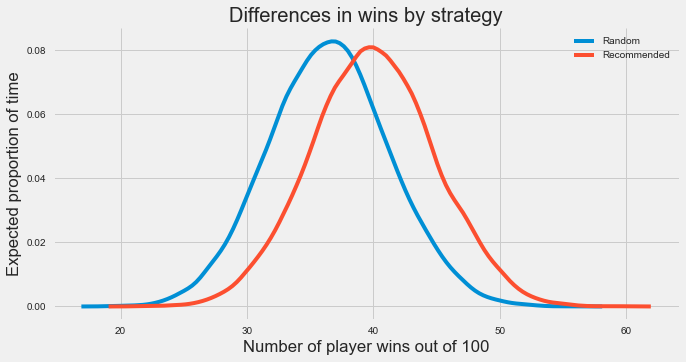

In [253]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(ran.player_wins, 
             hist=False, label="Random");
sns.distplot(rec.player_wins, 
             hist=False, label="Recommended");
ax.set_title("Differences in wins by strategy");
ax.set_ylabel("Expected proportion of time");
ax.set_xlabel("Number of player wins out of 100");
sns.despine();

In [254]:
# Is the difference significant?
stats.ttest_ind(ran.player_wins, rec.player_wins)

Ttest_indResult(statistic=-71.517242699505218, pvalue=0.0)

## Number of losses

$H_0$: There is no difference in expected number of losses for the player between a random strategy and a recommended strategy.

$H_1$: There is a difference in expected number of losses for the player between a random strategy and a recommended strategy.

Significance level, $\alpha$: 5%

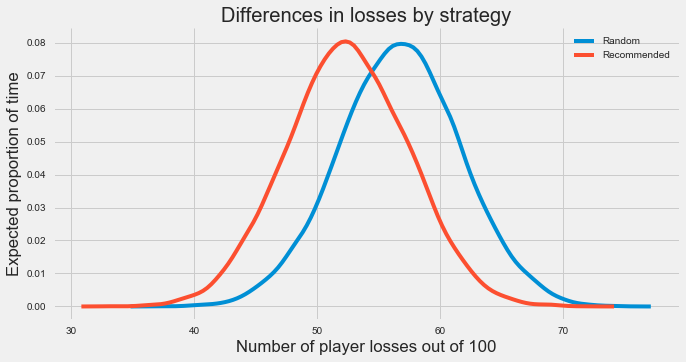

In [255]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(ran.player_loses, 
             hist=False, label="Random");
sns.distplot(rec.player_loses, 
             hist=False, label="Recommended");
ax.set_title("Differences in losses by strategy");
ax.set_ylabel("Expected proportion of time");
ax.set_xlabel("Number of player losses out of 100");
sns.despine();

In [256]:
# Is the difference significant?
stats.ttest_ind(ran.player_loses, rec.player_loses)

Ttest_indResult(statistic=85.727931623979302, pvalue=0.0)

## Number of busts

$H_0$: There is no difference in expected number of busts for the player between a random strategy and a recommended strategy.

$H_1$: There is a difference in expected number of busts for the player between a random strategy and a recommended strategy.

Significance level, $\alpha$: 5%

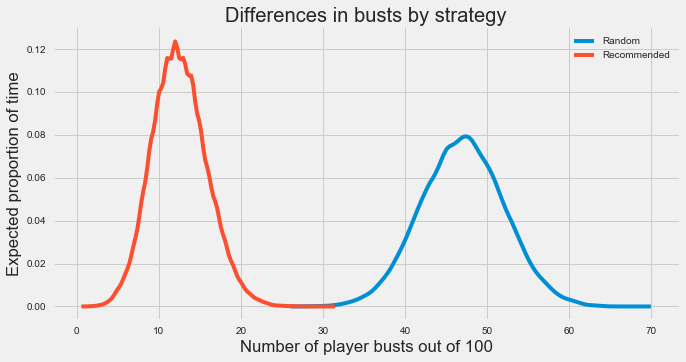

In [257]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(ran.player_busts, 
             hist=False, label="Random");
sns.distplot(rec.player_busts, 
             hist=False, label="Recommended");
ax.set_title("Differences in busts by strategy");
ax.set_ylabel("Expected proportion of time");
ax.set_xlabel("Number of player busts out of 100");
sns.despine();

In [258]:
# Is the difference significant?
stats.ttest_ind(ran.player_busts, rec.player_busts)

Ttest_indResult(statistic=809.28955462228976, pvalue=0.0)

## What about dealer busts?

$H_0$: There is no difference in expected number of busts for the dealer between a random strategy and a recommended strategy.

$H_1$: There is a difference in expected number of busts for the dealer between a random strategy and a recommended strategy.

Significance level, $\alpha$: 5%

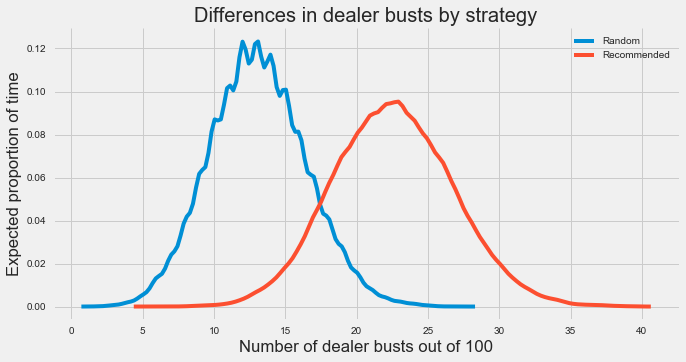

In [259]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(ran.dealer_busts, 
             hist=False, label="Random");
sns.distplot(rec.dealer_busts, 
             hist=False, label="Recommended");
ax.set_title("Differences in dealer busts by strategy");
ax.set_ylabel("Expected proportion of time");
ax.set_xlabel("Number of dealer busts out of 100");
sns.despine();

In [260]:
# Is the difference significant?
stats.ttest_ind(ran.dealer_busts, rec.dealer_busts)

Ttest_indResult(statistic=-249.91521271184726, pvalue=0.0)

## Findings

- Using the recommended strategy
    - Expected wins are greater
    - Expected losses are lower
    - Expected player busts are lower
    - Expected dealer busts are higher
        - Does this make sense?
        - Why would the player's strategy affect the dealer's hand?
- Seems like using the recommended strategy does improve our chances of winning
    - But is it enough?

# In-depth exploration

In [261]:
df.head()

,dealer_busts,dealer_final,dealer_hand,dealer_hit,dealer_initial,dealer_num_hits,dealer_open,draw,num_decks,player_busts,...,player_card_two,player_final,player_hand,player_hit,player_inital,player_initial,player_loses,player_num_hits,player_wins,strategy
0,0,19,"K,9",0,19,0,10,0,4,1,...,9,24,"9,9,6",1,18.0,NaN,1,1,0,0
1,0,20,"Q,10",0,20,0,10,0,4,1,...,6,24,"6,6,3,9",1,12.0,NaN,1,2,0,0
2,0,14,"4,Q",0,14,0,4,0,4,1,...,4,25,"5,4,6,J",1,9.0,NaN,1,2,0,0
3,0,10,"6,4",0,10,0,6,0,4,1,...,4,22,"Q,4,A,7",1,14.0,NaN,1,2,0,0
4,0,12,"8,4",0,12,0,8,0,4,1,...,4,22,"3,4,5,10",1,7.0,NaN,1,2,0,0


In [262]:
score_cols = ["player_loses", "draw", "player_wins"]

## Is splitting 8's always better than just keeping them?

- And does the strategy affect that?

In [263]:
def get_combi(cards):
    card_list = list(cards)
    card_list.sort()
    card_list = [str(i) for i in card_list]
    return "".join(card_list)

In [264]:
def get_other(cards, number):
    card_list = list(cards)
    card_list.remove(number)
    return card_list[0]

In [311]:
eights = df.copy()
eights = eights[(df.player_card_one == 8) | (df.player_card_two == 8)]
eights = eights[["player_card_one", "player_card_two", "player_wins", "strategy"]]
eights.reset_index(drop=True, inplace=True)

In [312]:
eights["combination"] = eights[["player_card_one", "player_card_two"]].apply(get_combi, axis=1)

In [313]:
eights.head()

,player_card_one,player_card_two,player_wins,strategy,combination
0,10,8,0,0,810
1,9,8,0,0,89
2,8,10,1,0,810
3,8,9,0,0,89
4,2,8,1,0,28


In [314]:
eights.shape

(11674, 5)

In [315]:
for i in range(eights.shape[0]):
    eights.ix[i, "other"] = get_other(eights[["player_card_one", "player_card_two"]].ix[i], 8)

In [316]:
eights["other"] = eights["other"].astype(int)

In [317]:
eights.head()

,player_card_one,player_card_two,player_wins,strategy,combination,other
0,10,8,0,0,810,10
1,9,8,0,0,89,9
2,8,10,1,0,810,10
3,8,9,0,0,89,9
4,2,8,1,0,28,2


In [318]:
eights.other.value_counts()

10    3760
4      964
7      956
5      945
2      939
1      931
6      927
3      921
9      916
8      415
Name: other, dtype: int64

In [319]:
eights.head()

,player_card_one,player_card_two,player_wins,strategy,combination,other
0,10,8,0,0,810,10
1,9,8,0,0,89,9
2,8,10,1,0,810,10
3,8,9,0,0,89,9
4,2,8,1,0,28,2


In [320]:
e_wins = eights.groupby(["strategy", "other"])["player_wins"].agg([sum, len])

In [321]:
e_wins

sum   len
strategy other           
0        1      255   464
         2      209   488
         3      203   444
         4      133   462
         5      125   496
         6       99   438
         7      119   481
         8       50   221
         9       71   445
         10     318  1856
1        1      277   467
         2      227   451
         3      248   477
         4      121   502
         5      119   449
         6      123   489
         7      121   475
         8       54   194
         9      136   471
         10     790  1904

In [322]:
e_wins["prob"] = e_wins["sum"]/e_wins["len"]

In [325]:
e_wins.reset_index(inplace=True)

In [363]:
ran = e_wins[e_wins["strategy"]==0].reset_index()
rec = e_wins[e_wins["strategy"]==1].reset_index()

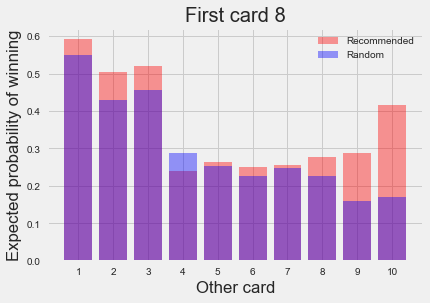

In [374]:
plt.bar(rec["other"], rec["prob"], 
        color="r", alpha=0.4, label="Recommended");
plt.bar(ran["other"], ran["prob"], 
        color="b", alpha=0.4, label="Random");
plt.title("First card 8");
plt.xticks(e_wins["other"].unique())
plt.xlabel("Other card");
plt.ylabel("Expected probability of winning");
plt.legend();

In [309]:
for i in range(1,11):
    if i != 8:
        r = stats.ttest_ind(eights["player_wins"][eights["other"]==i], eights["player_wins"][eights["other"]==8])
        if r.pvalue < 0.05:
            msg = "rejected."
        else:
            msg = "not rejected."
        print ("Null hypothesis: There is no difference in wins whether your second card is {} or 8.\nSignificance level = 5%".format(i))
        print ("Other card: {}\np-value: {:.6f}\np-value < 5%: {}\nNull hypothesis {}\n".format(i, r.pvalue, r.pvalue < 0.05, msg))

Null hypothesis: There is no difference in wins whether your second card is 1 or 8.
Significance level = 5%
Other card: 1
p-value: 0.000000
p-value < 5%: True
Null hypothesis rejected.

Null hypothesis: There is no difference in wins whether your second card is 2 or 8.
Significance level = 5%
Other card: 2
p-value: 0.000000
p-value < 5%: True
Null hypothesis rejected.

Null hypothesis: There is no difference in wins whether your second card is 3 or 8.
Significance level = 5%
Other card: 3
p-value: 0.000000
p-value < 5%: True
Null hypothesis rejected.

Null hypothesis: There is no difference in wins whether your second card is 4 or 8.
Significance level = 5%
Other card: 4
p-value: 0.309646
p-value < 5%: False
Null hypothesis not rejected.

Null hypothesis: There is no difference in wins whether your second card is 5 or 8.
Significance level = 5%
Other card: 5
p-value: 0.727200
p-value < 5%: False
Null hypothesis not rejected.

Null hypothesis: There is no difference in wins whether your

### What about other numbers

In [378]:
def test_doubles(number):
    num_df = df.copy()
    num_df = num_df[(num_df["player_card_one"]==number) | (num_df["player_card_two"]==number)]
    num_df = num_df[["player_card_one", "player_card_two", "player_wins", "strategy"]]
    num_df.reset_index(drop=True, inplace=True)
    num_df["combination"] = num_df[["player_card_one", "player_card_two"]].apply(get_combi, axis=1)

    for i in range(num_df.shape[0]):
        num_df.ix[i, "other"] = get_other(num_df[["player_card_one", "player_card_two"]].ix[i], number)
    
    num_wins = num_df.groupby(["strategy", "other"])["player_wins"].agg([sum, len])
    num_wins["prob"] = num_wins["sum"]/num_wins["len"]
    num_wins.reset_index(inplace=True)
    
    ran = num_wins[num_wins["strategy"]==0].reset_index()
    rec = num_wins[num_wins["strategy"]==1].reset_index()
    
    plt.bar(rec["other"], rec["prob"], 
        color="r", alpha=0.4, label="Recommended");
    plt.bar(ran["other"], ran["prob"], 
            color="b", alpha=0.4, label="Random");
    plt.title("First card {}".format(number));
    plt.xticks(num_wins["other"].unique())
    plt.xlabel("Other card");
    plt.ylabel("Expected probability of winning");
    plt.legend();
    
#     for i in range(1,11):
#         if i != number:
#             r = stats.ttest_ind(num_df["player_wins"][num_df["other"]==i], num_df["player_wins"][num_df["other"]==number])
#             if r.pvalue < 0.05:
#                 msg = "rejected."
#             else:
#                 msg = "not rejected."
#             print ("Null hypothesis: There is no difference in wins whether your second card is {} or {}.\nSignificance level = 5%".format(i, number))
#             print ("Other card: {}\np-value: {:.6f}\np-value < 5%: {}\nNull hypothesis {}\n".format(i, r.pvalue, r.pvalue < 0.05, msg))

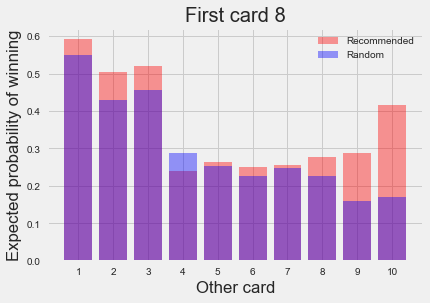

In [379]:
test_doubles(8)

In [ ]:
for i in range(1,11):
    test_doubles(i)

## Do we always do better when hitting on 12-16's?

In [286]:
sub1216 = df.copy()

In [288]:
sub1216 = sub1216[sub1216["player_initial"] >= 12]
sub1216 = sub1216[sub1216["player_initial"] <= 16]
sub1216

## Do we always do worse when hitting on 17's and above?